In [1]:
# Import useful packages
import pandas as pd
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot as plt
import time

# Import ML packages 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier	
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier		

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier

from tpot import TPOTClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import my functions 

from my_toolkit import *

os.chdir('/Users/camilleepitalon/Documents/DSB/11_machine_learning_2/Project')
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test-full.csv')

### Feature Engineering

- Create new features based on existing ones (linear combinaisons)
- Check feature importance and drop unsignificant ones

In [2]:
# Separate numerical and dummies columns
all_columns = list(df_train.columns)
columns = [col for col in df_test.columns if col != 'Id']
num_columns = [col for col in columns if 'Soil_Type' not in col and 'Wilderness_Area' not in col and 'Id' not in col]
dummy_cols = [col for col in columns if col not in num_columns and 'Id' not in col]
wilder_columns = [col for col in df_train.columns if 'Wilderness_Area' in col]
soil_columns = [col for col in df_train.columns if 'Soil_Type' in col]

print('-->', len(columns), 'features (+ the ID column)')
print('• ', len(num_columns), 'numerical features:\n', num_columns)
print('• ', len(dummy_cols), 'binary features:\n', dummy_cols)

--> 54 features (+ the ID column)
•  10 numerical features:
 ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']
•  44 binary features:
 ['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']


In [16]:
# Class parameters
df_train = df_train
df_test = df_test
model = None
add_eng_features = True
add_climate = True
add_geographic = True
add_family = True
add_rocky = True
add_stony = True
keep_initial_rows = False
columns_to_drop = None
random_state = 2

preprocessing_class = ClassifTools(df_train, df_test, model,
    add_eng_features,
    add_climate, add_geographic, add_family, add_rocky, add_stony,
    keep_initial_rows, columns_to_drop,
    random_state) 

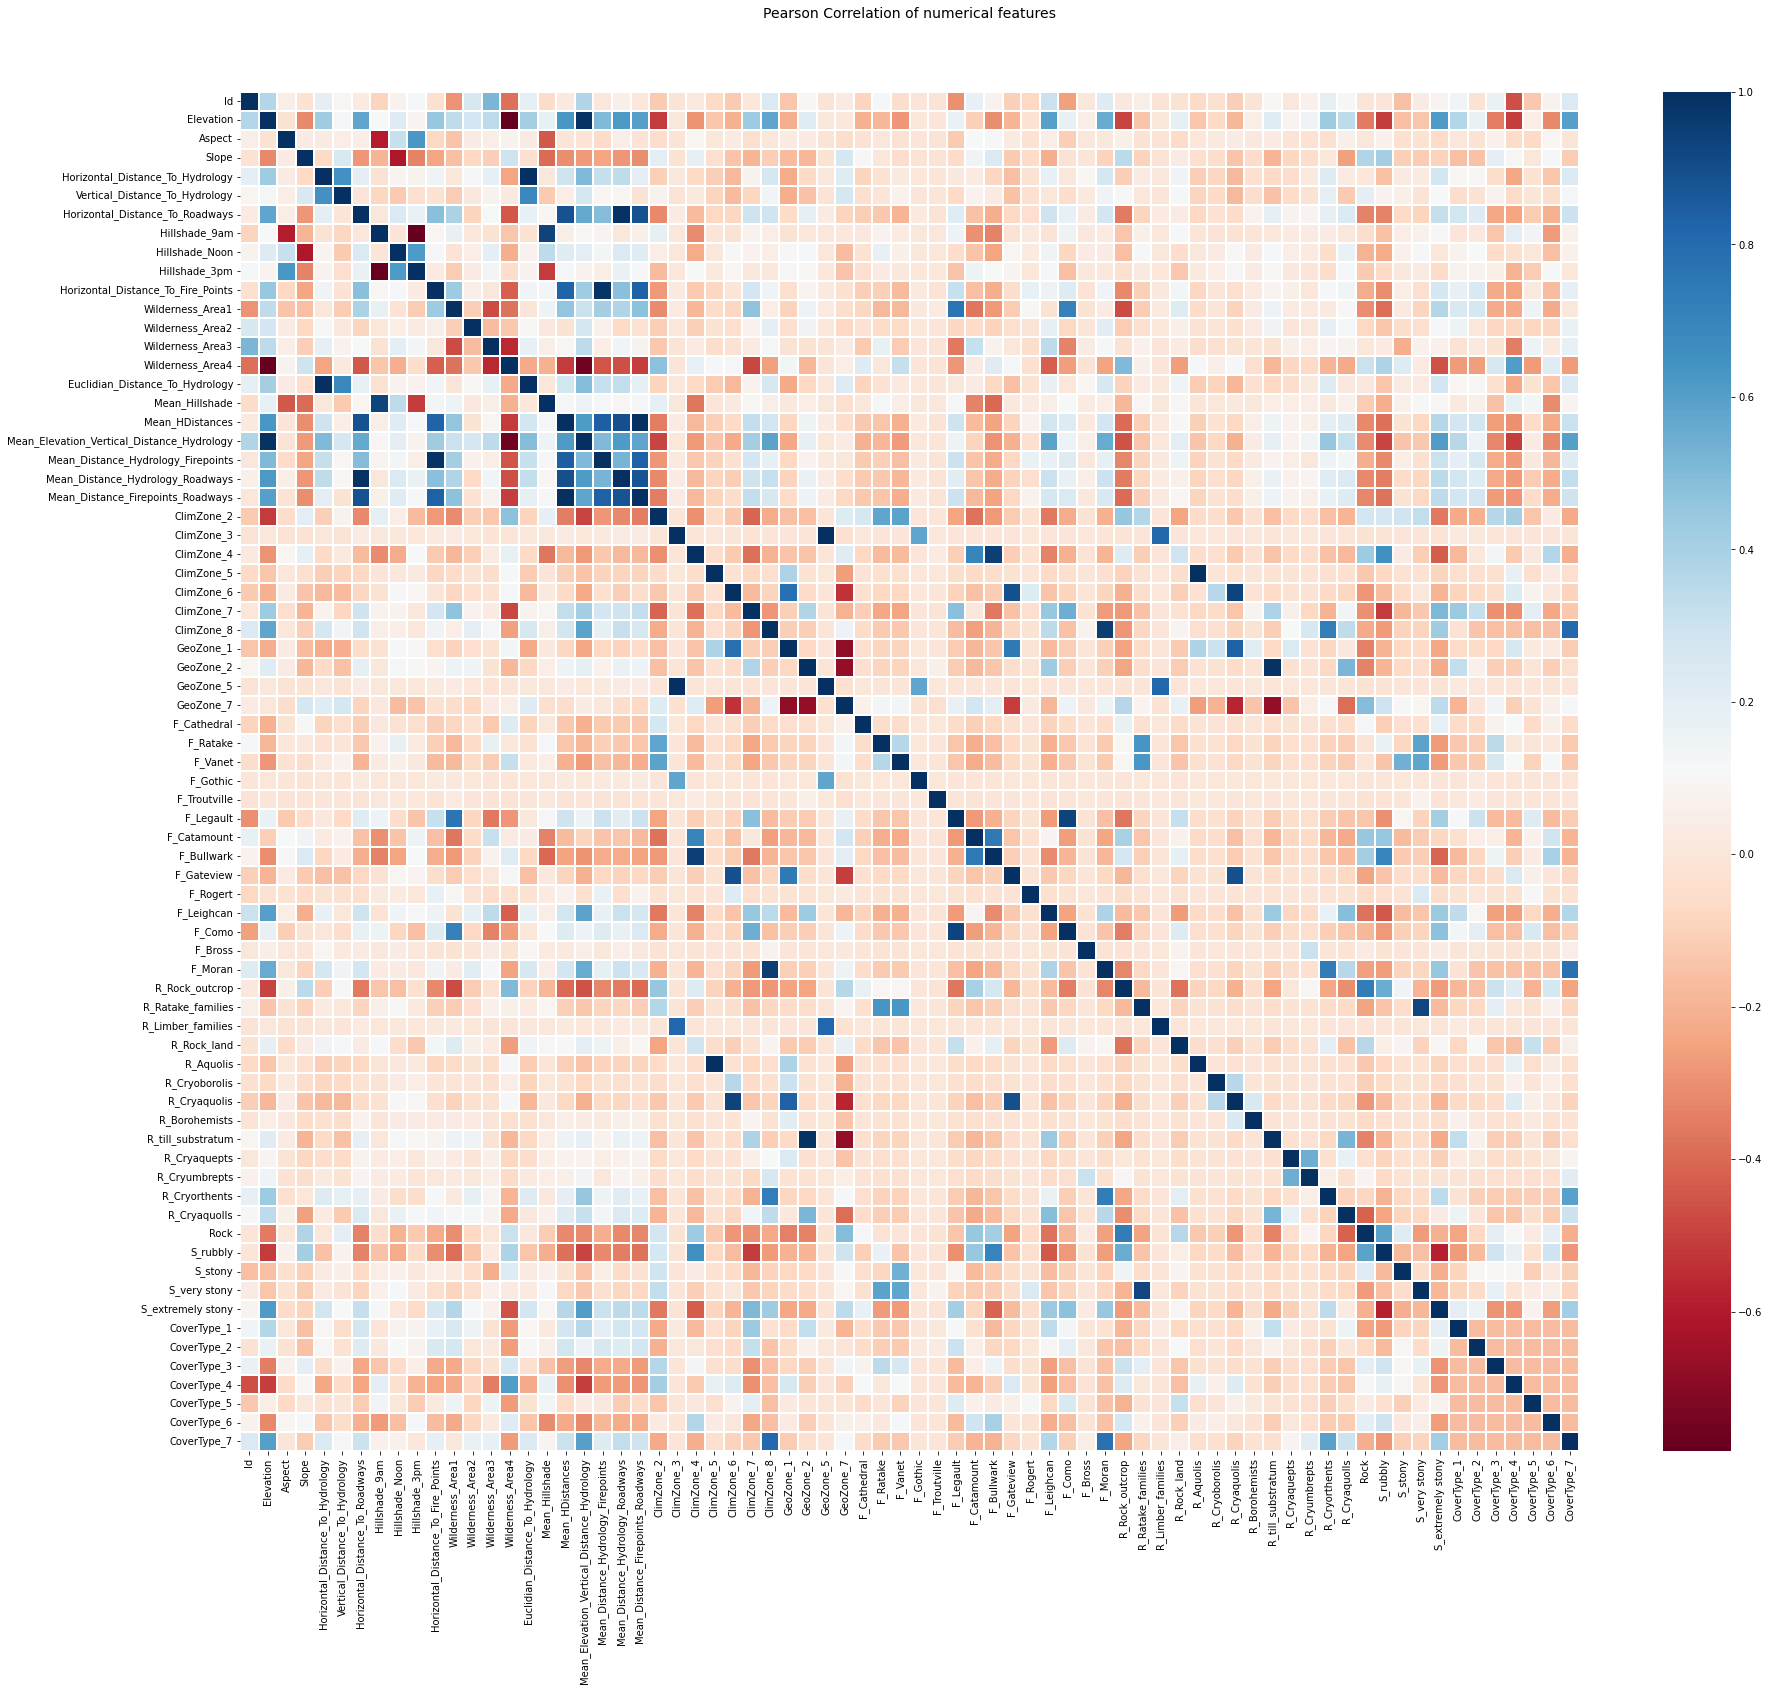

In [17]:
cl = preprocessing_class
df_enriched = cl.enrich_data(df_train)
df_enriched_enc = one_hot_encode(df_enriched, column_of_interest='Cover_Type', new_columns_prefix='CoverType')

# Plot Pearson Correlation of numerical features
plt.figure(figsize=(30,25))
sns.heatmap(df_enriched_enc.corr(),linewidths=0.1,vmax=1.0, 
            square=False, cmap=plt.cm.RdBu, linecolor='white', annot=False)
plt.title('Pearson Correlation of numerical features', y=1.05, size=14);

Looking at this chart, we see that many features have no impact onf the CoverTypes (same color for all of them). Let's remove them.

In [18]:
# Class parameters
df_train = df_train
df_test = df_test
model = None
add_eng_features = True
add_climate = True
add_geographic = True
add_family = True
add_rocky = True
add_stony = True
keep_initial_rows = False
columns_to_drop = ['ClimZone_3', 'GeoZone_5', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryaquolls']
random_state = 2

preprocessing_class = ClassifTools(df_train, df_test, model,
    add_eng_features,
    add_climate, add_geographic, add_family, add_rocky, add_stony,
    keep_initial_rows, columns_to_drop,
    random_state) 

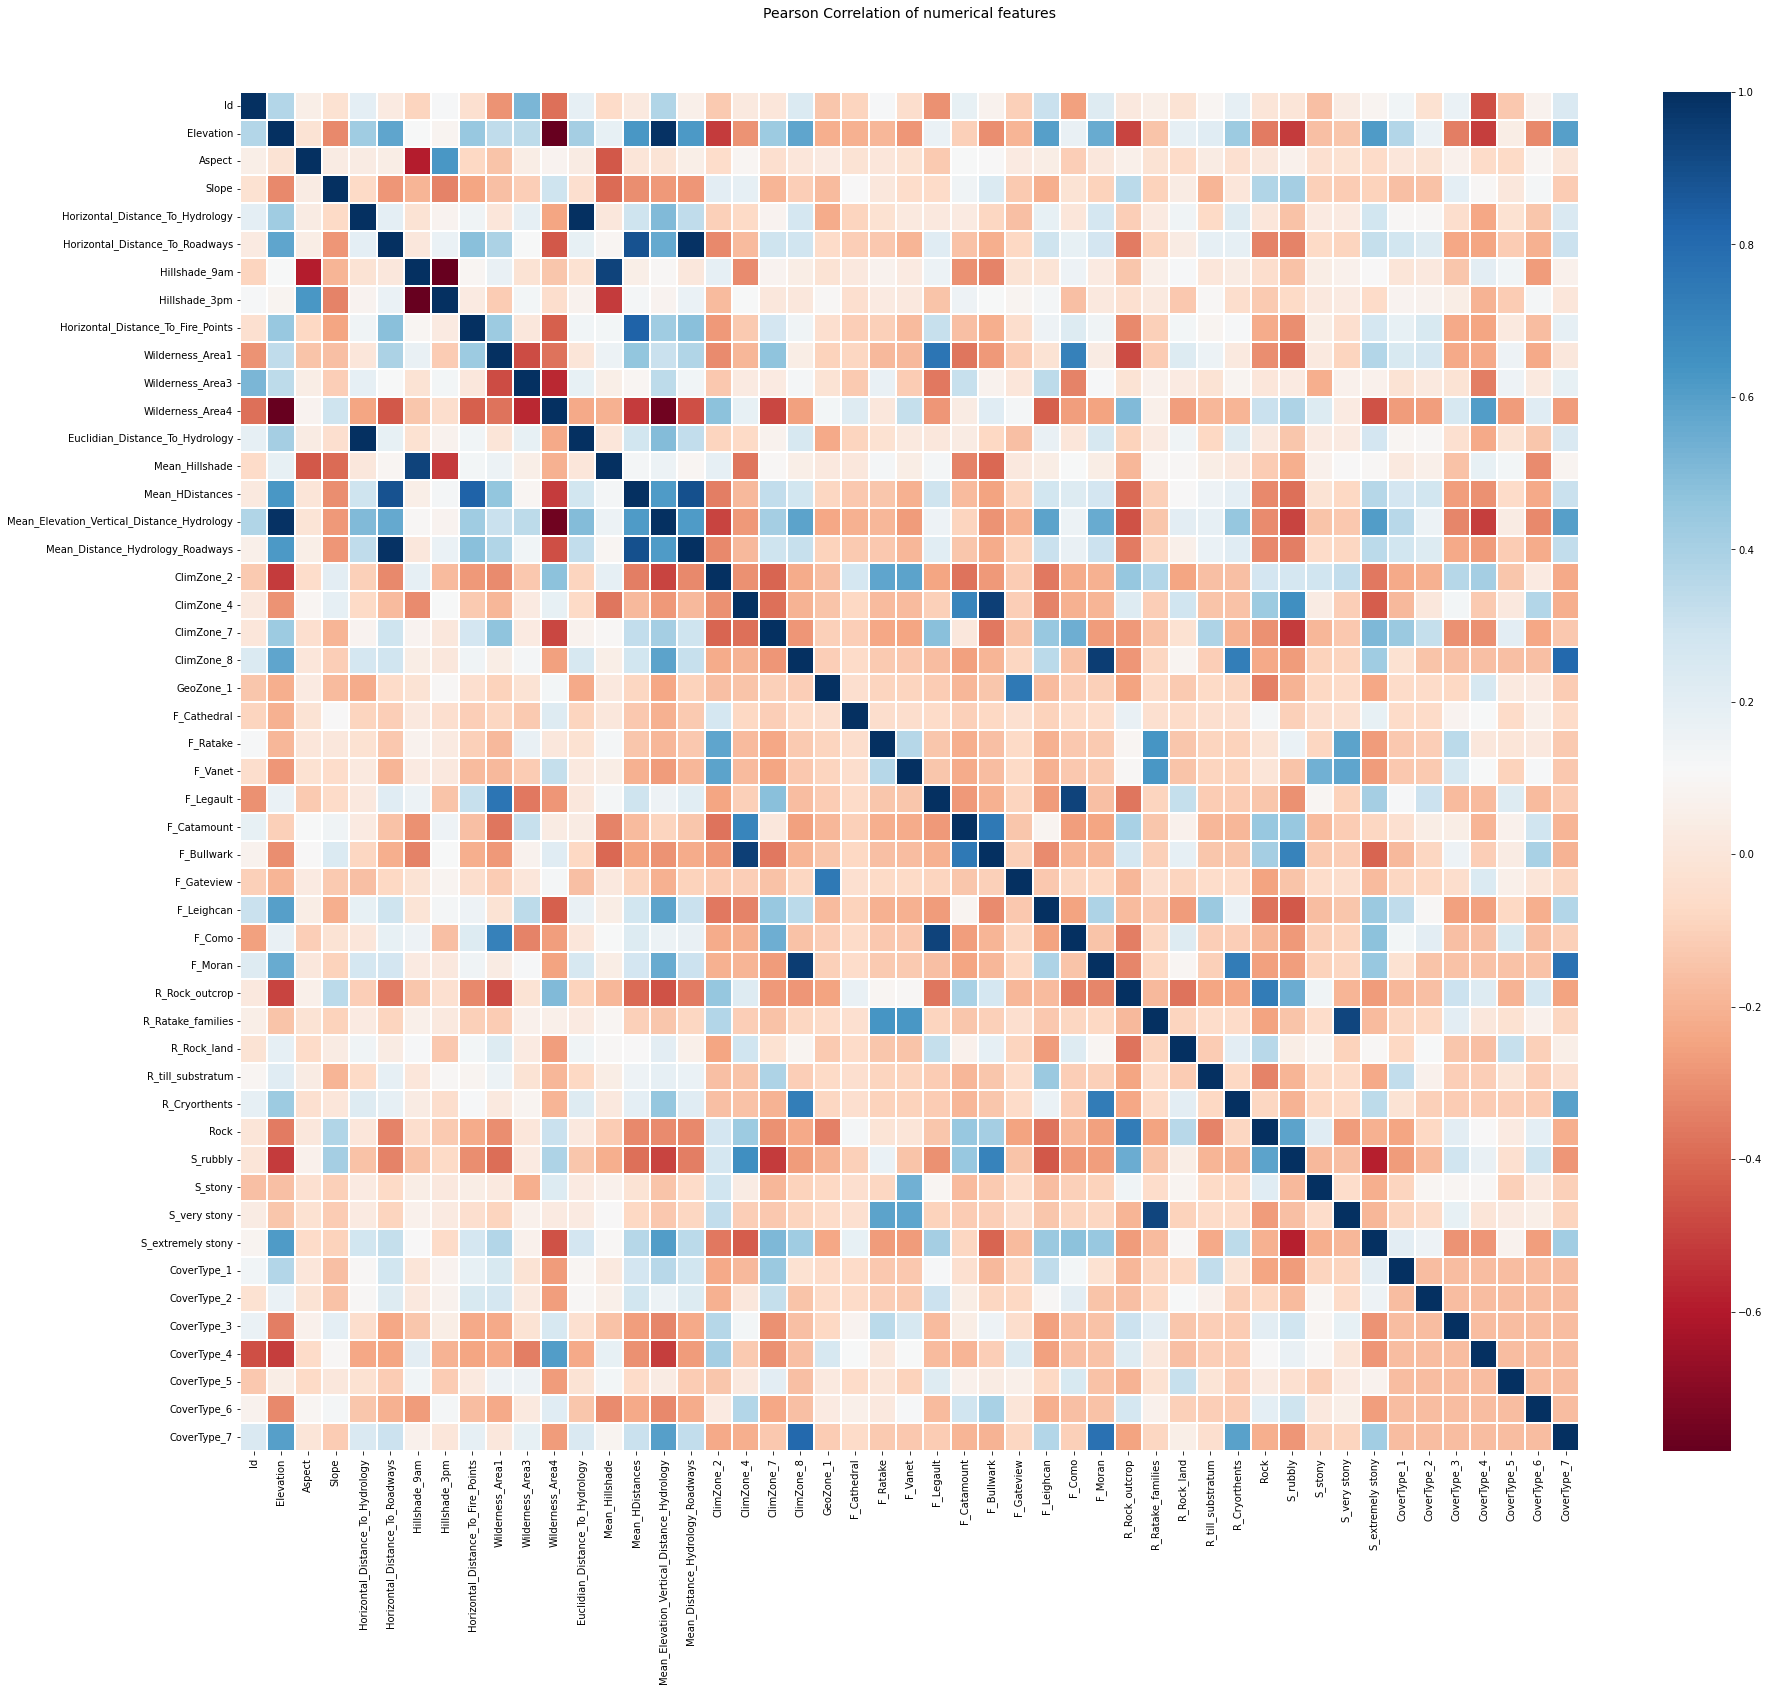

In [21]:
insignificant_features = ['Vertical_Distance_To_Hydrology','Hillshade_Noon', 'Mean_Distance_Hydrology_Firepoints', 'Mean_Distance_Firepoints_Roadways', 'Wilderness_Area2', 'ClimZone_3', 'ClimZone_5', 'ClimZone_6', 'GeoZone_2','GeoZone_5', 'GeoZone_7', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryumbrepts', 'R_Cryaquolls']
significant_features = [col for col in df_enriched_enc if col not in insignificant_features]
# Plot Pearson Correlation of numerical features
plt.figure(figsize=(30,25))
sns.heatmap(df_enriched_enc[significant_features].corr(),linewidths=0.1,vmax=1.0, 
            square=False, cmap=plt.cm.RdBu, linecolor='white', annot=False)
plt.title('Pearson Correlation of numerical features', y=1.05, size=14);

### Modelling

In [6]:
# Class parameters
df_train = df_train
df_test = df_test
model = LGBMClassifier()
#model = LGBMClassifier(learning_rate=0.01, max_depth=32, num_iterations=1024, num_leaves=512, n_jobs=-1)
#model = ExtraTreesClassifier(n_estimators=300, max_features = None, min_samples_leaf= 1, min_samples_split= 2)
#model = LogisticRegression()
add_eng_features = True
add_climate = True
add_geographic = True
add_family = True
add_rocky = True
add_stony = True
keep_initial_rows = False
columns_to_drop = ['ClimZone_3', 'GeoZone_5', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryaquolls']
random_state = 2

modelling_class = ClassifTools(df_train, df_test, model,
    add_eng_features,
    add_climate, add_geographic, add_family, add_rocky, add_stony,
    keep_initial_rows, columns_to_drop,
    random_state)

In [7]:
cl = modelling_class
pred, acc, mat, pred_time = cl.test_predict(export_file=True, compute_local_metrics=True)
export_metrics(acc, mat, pred_time, cl)
print_results(acc, mat, pred_time, cl)

enriching the data...
number of features: 52
   -- took 51.75 sec
training model...
   -- took 0.86 sec
predicting test_set...
   -- took 2.54 sec
exporting file...
computing local metrics...
   -- took 2.51 sec
> SUCCESS
-------------------------
- Parameters:  {'model': LGBMClassifier(), 'add_eng_features': True, 'add_climate': True, 'add_geographic': True, 'add_family': True, 'add_rocky': True, 'add_stony': True, 'keep_initial_rows': False, 'columns_to_drop': ['ClimZone_3', 'GeoZone_5', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryaquolls'], 'random_state': 2}
- Execution time: 58.4
- Accuracy: 0.8991
- Confusion matrix:


,true1,true2,true3,true4,true5,true6,true7
pred1,363,55,0,0,5,0,20
pred2,59,313,11,0,23,8,3
pred3,0,1,364,13,3,30,0
pred4,0,0,4,429,0,3,0
pred5,0,14,2,0,395,2,0
pred6,0,1,28,12,3,414,0
pred7,5,0,0,0,0,0,441


In [11]:
# Class parameters
df_train = df_train
df_test = df_test
#model = LGBMClassifier()
#model = LGBMClassifier(learning_rate=0.01, max_depth=32, num_iterations=1024, num_leaves=512, n_jobs=-1)
model = ExtraTreesClassifier(n_estimators=300, max_features = None, min_samples_leaf= 1, min_samples_split= 2)
add_eng_features = True
add_climate = True
add_geographic = True
add_family = True
add_rocky = True
add_stony = True
keep_initial_rows = False
columns_to_drop = None
random_state = 2

modelling_class2 = ClassifTools(df_train, df_test, model,
    add_eng_features,
    add_climate, add_geographic, add_family, add_rocky, add_stony,
    keep_initial_rows, columns_to_drop,
    random_state)

In [12]:
cl = modelling_class2
pred, acc, mat, pred_time = cl.test_predict(export_file=True, compute_local_metrics=True)
export_metrics(acc, mat, pred_time, cl)
print_results(acc, mat, pred_time, cl)

enriching the data...
number of features: 65
   -- took 52.66 sec
training model...
   -- took 13.8 sec
predicting test_set...
   -- took 20.24 sec
exporting file...
computing local metrics...
   -- took 13.0 sec
> SUCCESS
-------------------------
- Parameters:  {'model': ExtraTreesClassifier(max_features=None, n_estimators=300), 'add_eng_features': True, 'add_climate': True, 'add_geographic': True, 'add_family': True, 'add_rocky': True, 'add_stony': True, 'keep_initial_rows': False, 'columns_to_drop': None, 'random_state': 2}
- Execution time: 100.33
- Accuracy: 0.9021
- Confusion matrix:


,true1,true2,true3,true4,true5,true6,true7
pred1,361,54,0,0,3,0,25
pred2,60,319,11,0,18,7,2
pred3,0,2,371,13,2,23,0
pred4,0,0,6,428,0,2,0
pred5,1,9,2,0,399,2,0
pred6,0,0,31,13,2,412,0
pred7,8,0,0,0,0,0,438


In [23]:
# Class parameters
df_train = df_train
df_test = df_test
#model = LGBMClassifier()
#model = LGBMClassifier(learning_rate=0.01, max_depth=32, num_iterations=1024, num_leaves=512, n_jobs=-1)
model = ExtraTreesClassifier(n_estimators=300, max_features = None, min_samples_leaf= 1, min_samples_split= 2)
add_eng_features = True
add_climate = True
add_geographic = True
add_family = True
add_rocky = True
add_stony = True
keep_initial_rows = False
columns_to_drop = ['Vertical_Distance_To_Hydrology','Hillshade_Noon', 'Mean_Distance_Hydrology_Firepoints', 'Mean_Distance_Firepoints_Roadways', 'Wilderness_Area2', 'ClimZone_3', 'ClimZone_5', 'ClimZone_6', 'GeoZone_2','GeoZone_5', 'GeoZone_7', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryumbrepts', 'R_Cryaquolls']
random_state = 2

modelling_class3 = ClassifTools(df_train, df_test, model,
    add_eng_features,
    add_climate, add_geographic, add_family, add_rocky, add_stony,
    keep_initial_rows, columns_to_drop,
    random_state)

cl = modelling_class3
pred, acc, mat, pred_time = cl.test_predict(export_file=True, compute_local_metrics=True)
export_metrics(acc, mat, pred_time, cl)
print_results(acc, mat, pred_time, cl)

enriching the data...
number of features: 42
   -- took 54.78 sec
training model...
   -- took 11.46 sec
predicting test_set...
   -- took 19.99 sec
exporting file...
computing local metrics...
   -- took 11.08 sec
> SUCCESS
-------------------------
- Parameters:  {'model': ExtraTreesClassifier(max_features=None, n_estimators=300), 'add_eng_features': True, 'add_climate': True, 'add_geographic': True, 'add_family': True, 'add_rocky': True, 'add_stony': True, 'keep_initial_rows': False, 'columns_to_drop': ['Vertical_Distance_To_Hydrology', 'Hillshade_Noon', 'Mean_Distance_Hydrology_Firepoints', 'Mean_Distance_Firepoints_Roadways', 'Wilderness_Area2', 'ClimZone_3', 'ClimZone_5', 'ClimZone_6', 'GeoZone_2', 'GeoZone_5', 'GeoZone_7', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryumbrepts', 'R_Cryaquolls'], 'random_state': 2}
- Execution time: 97.94
- Accuracy: 0.9005
- Confusion m

,true1,true2,true3,true4,true5,true6,true7
pred1,364,49,0,0,4,0,26
pred2,60,318,11,0,19,7,2
pred3,0,2,369,11,2,27,0
pred4,0,0,7,426,0,3,0
pred5,1,12,2,0,396,2,0
pred6,0,0,29,13,2,414,0
pred7,10,0,0,0,0,0,436


In [24]:
# Class parameters
df_train = df_train
df_test = df_test
#model = LGBMClassifier()
#model = LGBMClassifier(learning_rate=0.01, max_depth=32, num_iterations=1024, num_leaves=512, n_jobs=-1)
model = ExtraTreesClassifier(n_estimators=300, max_features = None, min_samples_leaf= 1, min_samples_split= 2)
add_eng_features = False
add_climate = True
add_geographic = True
add_family = True
add_rocky = True
add_stony = True
keep_initial_rows = False
columns_to_drop = ['Vertical_Distance_To_Hydrology','Hillshade_Noon', 'Mean_Distance_Hydrology_Firepoints', 'Mean_Distance_Firepoints_Roadways', 'Wilderness_Area2', 'ClimZone_3', 'ClimZone_5', 'ClimZone_6', 'GeoZone_2','GeoZone_5', 'GeoZone_7', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryumbrepts', 'R_Cryaquolls']
random_state = 2

modelling_class3 = ClassifTools(df_train, df_test, model,
    add_eng_features,
    add_climate, add_geographic, add_family, add_rocky, add_stony,
    keep_initial_rows, columns_to_drop,
    random_state)

cl = modelling_class3
pred, acc, mat, pred_time = cl.test_predict(export_file=True, compute_local_metrics=True)
export_metrics(acc, mat, pred_time, cl)
print_results(acc, mat, pred_time, cl)

enriching the data...
number of features: 37
   -- took 53.23 sec
training model...
   -- took 9.13 sec
predicting test_set...
   -- took 19.88 sec
exporting file...
computing local metrics...
   -- took 8.56 sec
> SUCCESS
-------------------------
- Parameters:  {'model': ExtraTreesClassifier(max_features=None, n_estimators=300), 'add_eng_features': False, 'add_climate': True, 'add_geographic': True, 'add_family': True, 'add_rocky': True, 'add_stony': True, 'keep_initial_rows': False, 'columns_to_drop': ['Vertical_Distance_To_Hydrology', 'Hillshade_Noon', 'Mean_Distance_Hydrology_Firepoints', 'Mean_Distance_Firepoints_Roadways', 'Wilderness_Area2', 'ClimZone_3', 'ClimZone_5', 'ClimZone_6', 'GeoZone_2', 'GeoZone_5', 'GeoZone_7', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryumbrepts', 'R_Cryaquolls'], 'random_state': 2}
- Execution time: 91.5
- Accuracy: 0.8998
- Confusion mat

,true1,true2,true3,true4,true5,true6,true7
pred1,362,50,0,0,5,0,26
pred2,55,323,10,0,18,9,2
pred3,0,2,367,15,3,24,0
pred4,0,0,7,426,0,3,0
pred5,0,16,2,0,393,2,0
pred6,0,1,31,10,3,413,0
pred7,9,0,0,0,0,0,437


In [25]:
# Class parameters
df_train = df_train
df_test = df_test
#model = LGBMClassifier()
#model = LGBMClassifier(learning_rate=0.01, max_depth=32, num_iterations=1024, num_leaves=512, n_jobs=-1)
model = ExtraTreesClassifier(n_estimators=300, max_features = None, min_samples_leaf= 1, min_samples_split= 2)
add_eng_features = False
add_climate = False
add_geographic = False
add_family = True
add_rocky = True
add_stony = True
keep_initial_rows = False
columns_to_drop = ['F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryumbrepts', 'R_Cryaquolls']
random_state = 2

modelling_class4 = ClassifTools(df_train, df_test, model,
    add_eng_features,
    add_climate, add_geographic, add_family, add_rocky, add_stony,
    keep_initial_rows, columns_to_drop,
    random_state)

cl = modelling_class4
pred, acc, mat, pred_time = cl.test_predict(export_file=True, compute_local_metrics=True)
export_metrics(acc, mat, pred_time, cl)
print_results(acc, mat, pred_time, cl)

enriching the data...
number of features: 35
   -- took 55.09 sec
training model...
   -- took 9.99 sec
predicting test_set...
   -- took 20.18 sec
exporting file...
computing local metrics...
   -- took 10.04 sec
> SUCCESS
-------------------------
- Parameters:  {'model': ExtraTreesClassifier(max_features=None, n_estimators=300), 'add_eng_features': False, 'add_climate': False, 'add_geographic': False, 'add_family': True, 'add_rocky': True, 'add_stony': True, 'keep_initial_rows': False, 'columns_to_drop': ['F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryumbrepts', 'R_Cryaquolls'], 'random_state': 2}
- Execution time: 95.96
- Accuracy: 0.9028
- Confusion matrix:


,true1,true2,true3,true4,true5,true6,true7
pred1,363,52,0,0,3,0,25
pred2,55,321,11,0,20,7,3
pred3,0,2,375,12,2,20,0
pred4,0,0,6,428,0,2,0
pred5,1,15,2,0,393,2,0
pred6,0,0,33,10,3,412,0
pred7,8,0,0,0,0,0,438


In [26]:
# Class parameters
df_train = df_train
df_test = df_test
#model = LGBMClassifier()
#model = LGBMClassifier(learning_rate=0.01, max_depth=32, num_iterations=1024, num_leaves=512, n_jobs=-1)
model = ExtraTreesClassifier(n_estimators=300, max_features = None, min_samples_leaf= 1, min_samples_split= 2)
add_eng_features = True
add_climate = True
add_geographic = True
add_family = True
add_rocky = True
add_stony = True
keep_initial_rows = True
columns_to_drop = None
random_state = 2

modelling_class4 = ClassifTools(df_train, df_test, model,
    add_eng_features,
    add_climate, add_geographic, add_family, add_rocky, add_stony,
    keep_initial_rows, columns_to_drop,
    random_state)

cl = modelling_class4
pred, acc, mat, pred_time = cl.test_predict(export_file=True, compute_local_metrics=True)
export_metrics(acc, mat, pred_time, cl)
print_results(acc, mat, pred_time, cl)

enriching the data...
number of features: 105
   -- took 52.76 sec
training model...
   -- took 17.32 sec
predicting test_set...
   -- took 21.67 sec
exporting file...
computing local metrics...
   -- took 15.54 sec
> SUCCESS
-------------------------
- Parameters:  {'model': ExtraTreesClassifier(max_features=None, n_estimators=300), 'add_eng_features': True, 'add_climate': True, 'add_geographic': True, 'add_family': True, 'add_rocky': True, 'add_stony': True, 'keep_initial_rows': True, 'columns_to_drop': None, 'random_state': 2}
- Execution time: 107.92
- Accuracy: 0.9061
- Confusion matrix:


,true1,true2,true3,true4,true5,true6,true7
pred1,362,52,0,0,3,0,26
pred2,51,330,11,0,16,7,2
pred3,0,2,371,13,2,23,0
pred4,0,0,6,429,0,1,0
pred5,1,11,2,0,397,2,0
pred6,0,0,29,12,4,413,0
pred7,8,0,0,0,0,0,438


In [27]:
# Class parameters
df_train = df_train
df_test = df_test
model = LGBMClassifier()
#model = LGBMClassifier(learning_rate=0.01, max_depth=32, num_iteration=1024, num_leaves=512, n_jobs=-1)
#model = ExtraTreesClassifier(n_estimators=300, max_features = None, min_samples_leaf= 1, min_samples_split= 2)
add_eng_features = True
add_climate = True
add_geographic = True
add_family = True
add_rocky = True
add_stony = True
keep_initial_rows = False
columns_to_drop = ['ClimZone_3', 'GeoZone_5', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryaquolls']
random_state = 2

modelling_class5 = ClassifTools(df_train, df_test, model,
    add_eng_features,
    add_climate, add_geographic, add_family, add_rocky, add_stony,
    keep_initial_rows, columns_to_drop,
    random_state)

cl = modelling_class5
pred, acc, mat, pred_time = cl.test_predict(export_file=True, compute_local_metrics=True)
export_metrics(acc, mat, pred_time, cl)
print_results(acc, mat, pred_time, cl)

enriching the data...
number of features: 52
   -- took 52.29 sec
training model...


/Users/camilleepitalon/miniconda3/envs/DS/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


   -- took 113.05 sec
predicting test_set...
   -- took 391.15 sec
exporting file...
computing local metrics...


/Users/camilleepitalon/miniconda3/envs/DS/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


   -- took 132.06 sec
> SUCCESS
-------------------------
- Parameters:  {'model': LGBMClassifier(learning_rate=0.01, max_depth=32, num_iterations=1024,
               num_leaves=512), 'add_eng_features': True, 'add_climate': True, 'add_geographic': True, 'add_family': True, 'add_rocky': True, 'add_stony': True, 'keep_initial_rows': False, 'columns_to_drop': ['ClimZone_3', 'GeoZone_5', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryaquolls'], 'random_state': 2}
- Execution time: 689.22
- Accuracy: 0.9134
- Confusion matrix:


,true1,true2,true3,true4,true5,true6,true7
pred1,370,49,0,0,5,0,19
pred2,49,330,10,0,19,7,2
pred3,0,4,370,11,3,23,0
pred4,0,0,3,431,0,2,0
pred5,1,10,3,0,398,1,0
pred6,0,0,24,10,2,422,0
pred7,5,0,0,0,0,0,441


In [4]:
# Keeping soil12 and 22

# Class parameters
df_train = df_train
df_test = df_test
model = LGBMClassifier()
model = LGBMClassifier(learning_rate=0.01, max_depth=32, n_estimators=1024, num_leaves=512, n_jobs=-1)
#model = ExtraTreesClassifier(n_estimators=300, max_features = None, min_samples_leaf= 1, min_samples_split= 2)
add_eng_features = True
add_climate = True
add_geographic = True
add_family = True
add_rocky = True
add_stony = True
keep_initial_rows = False
columns_to_drop = ['ClimZone_3', 'GeoZone_5', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryaquolls']
random_state = 2

modelling_class6 = ClassifTools(df_train, df_test, model,
    add_eng_features,
    add_climate, add_geographic, add_family, add_rocky, add_stony,
    keep_initial_rows, columns_to_drop,
    random_state)

cl = modelling_class6
pred, acc, mat, pred_time = cl.test_predict(export_file=True, compute_local_metrics=True)
export_metrics(acc, mat, pred_time, cl)
print_results(acc, mat, pred_time, cl)

enriching the data...
number of features: 54
   -- took 51.98 sec
training model...
   -- took 109.31 sec
predicting test_set...
   -- took 356.99 sec
exporting file...
computing local metrics...
   -- took 182.82 sec
> SUCCESS
-------------------------
- Parameters:  {'model': LGBMClassifier(learning_rate=0.01, max_depth=32, n_estimators=1024,
               num_leaves=512), 'add_eng_features': True, 'add_climate': True, 'add_geographic': True, 'add_family': True, 'add_rocky': True, 'add_stony': True, 'keep_initial_rows': False, 'columns_to_drop': ['ClimZone_3', 'GeoZone_5', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryaquolls'], 'random_state': 2}
- Execution time: 702.08
- Accuracy: 0.9124
- Confusion matrix:


,true1,true2,true3,true4,true5,true6,true7
pred1,372,49,0,0,5,0,17
pred2,52,331,10,0,17,5,2
pred3,0,4,370,12,2,23,0
pred4,0,0,4,430,0,2,0
pred5,1,9,4,0,398,1,0
pred6,0,0,27,11,2,418,0
pred7,6,0,0,0,0,0,440


In [6]:
# Keeping soil12 and 22

# Class parameters
df_train = df_train
df_test = df_test
#model = LGBMClassifier()
#model = LGBMClassifier(learning_rate=0.01, max_depth=32, n_estimators=1024, num_leaves=512, n_jobs=-1)
#model = ExtraTreesClassifier(n_estimators=300, max_features = None, min_samples_leaf= 1, min_samples_split= 2)
model = TPOTClassifier()
add_eng_features = True
add_climate = True
add_geographic = True
add_family = True
add_rocky = True
add_stony = True
keep_initial_rows = False
columns_to_drop = ['ClimZone_3', 'GeoZone_5', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryaquolls']
random_state = 2

modelling_class6 = ClassifTools(df_train, df_test, model,
    add_eng_features,
    add_climate, add_geographic, add_family, add_rocky, add_stony,
    keep_initial_rows, columns_to_drop,
    random_state)

cl = modelling_class6
pred, acc, mat, pred_time = cl.test_predict(export_file=True, compute_local_metrics=True)
export_metrics(acc, mat, pred_time, cl)
print_results(acc, mat, pred_time, cl)

enriching the data...
number of features: 54
   -- took 73.58 sec
training model...


/Users/camilleepitalon/miniconda3/envs/DS/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


   -- took 7944.93 sec
predicting test_set...
   -- took 7.7 sec
exporting file...
computing local metrics...
   -- took 287.8 sec
> SUCCESS
-------------------------
- Parameters:  {'model': TPOTClassifier(), 'add_eng_features': True, 'add_climate': True, 'add_geographic': True, 'add_family': True, 'add_rocky': True, 'add_stony': True, 'keep_initial_rows': False, 'columns_to_drop': ['ClimZone_3', 'GeoZone_5', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryaquolls'], 'random_state': 2}
- Execution time: 8314.72
- Accuracy: 0.8833
- Confusion matrix:


,true1,true2,true3,true4,true5,true6,true7
pred1,342,71,0,0,4,0,26
pred2,61,314,9,0,22,5,6
pred3,0,5,355,16,3,32,0
pred4,0,0,4,428,0,4,0
pred5,2,16,4,0,386,5,0
pred6,0,1,29,12,5,411,0
pred7,11,0,0,0,0,0,435
